In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

%matplotlib widget


def fdata(x, L):
    A = L/10.0
    return 2*np.sin(2*np.pi*x/L) + x*(L-x)**2/L**3 * np.cos(x) + \
           5*x*(L-x)/L**2 + A/2 + 0.1*A*np.sin(13*np.pi*x/L)

N = 2048
L = 50.0
x = np.linspace(0, L, N, endpoint=False)
orig = fdata(x, L)
noisy = orig + 0.5*np.random.randn(N)


plt.plot(x, noisy)
plt.plot(x, orig)



In [3]:
# Convolve the noisy data with a Gaussian and plot the result together with the original data orig. 
# You'll need to play with the width of the Gaussian to get a nice smoothing. You also will need to normalize the Gaussian so that it sums to 1, otherwise, your convolved data will be shifted verfically from the original function.

from scipy.signal.windows import gaussian

# Initiating the gaussian kernel using the scipy.signal.windows method

sigma = 7

M = 49 # Set kernel size to cover 7 sigma for accurate edge truncation

Gauss = gaussian(M, sigma)  # Generate the Gaussian

Gauss = Gauss / np.sum(Gauss) # Normalization of the Gaussian 

Gaussian_smooth = scipy.signal.convolve(noisy, Gauss, mode='same', method='auto') # chosen option same to keep output of the same lenght

plt.plot(x, noisy)
plt.plot(x, orig)
plt.plot(x, Gaussian_smooth)

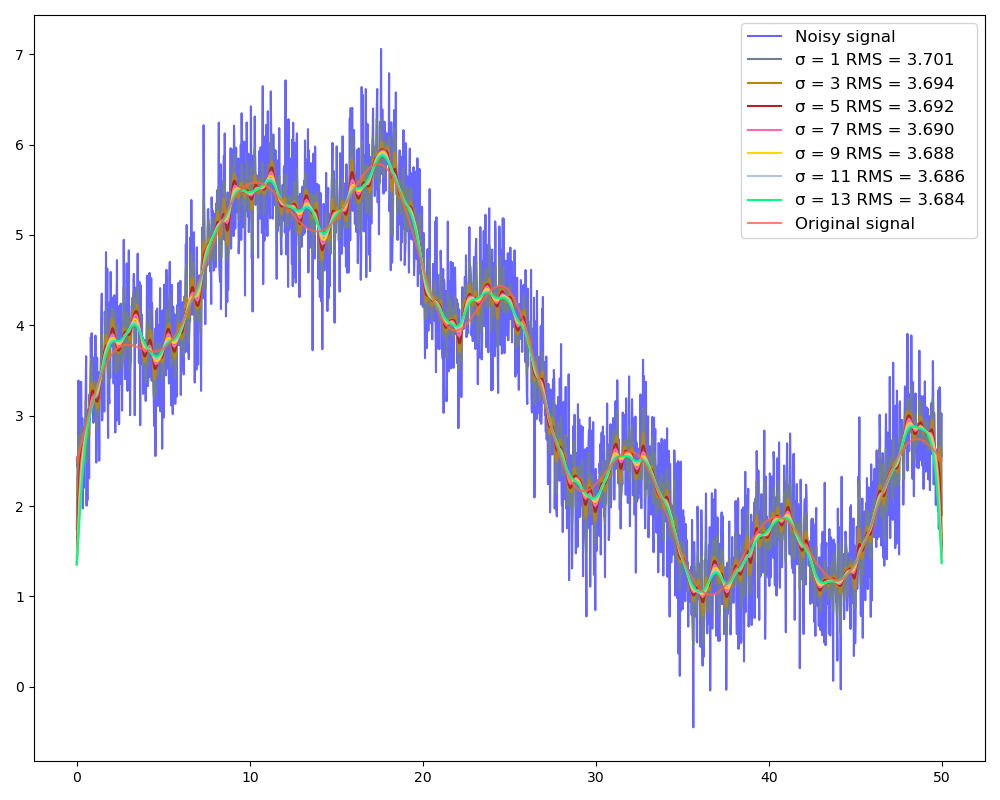

In [4]:
# Test with different widths, computing simple RMS as indication for Gaussian smoothing

colors = ['slategrey','darkgoldenrod','firebrick','hotpink','gold','lightsteelblue','springgreen']

def RMS(signal):
    rms = np.sqrt(np.mean(np.square(signal)))
    return rms

def Gauss_generator(sigma):
    M = 7*sigma 
    if M % 2 != 0:   # implement odd kernel generator to obtain better truncation
        Gauss = gaussian(M, sigma)  # Generate the Gaussian
        Gauss = Gauss / np.sum(Gauss) 
        return Gauss
    else: 
        M += 1
        Gauss = gaussian(M, sigma)  # Generate the Gaussian
        Gauss = Gauss / np.sum(Gauss)
        return Gauss


sigmas = np.array([1,3,5,7,9,11,13])  # different widths for gaussian smoothing, always M = sigma*7

Gaussians = []
RMSs = []

for i in range(len(sigmas)):
    Gauss_boi = Gauss_generator(sigmas[i])
    Gaussian_smooth = scipy.signal.convolve(noisy, Gauss_boi, mode='same', method='auto')
    Gaussians.append(Gaussian_smooth)
    rms = RMS(Gaussian_smooth)
    RMSs.append(rms)


plt.figure(figsize=(10, 8))
plt.plot(x,noisy, color='blue', alpha=0.6, label='Noisy signal')

for k in range(len(sigmas)):
    plt.plot(x,Gaussians[k], color=colors[k], alpha=1, label=f"σ = {sigmas[k]:.0f} RMS = {RMSs[k]:.3f} ")

plt.plot(x,orig, color='tomato', alpha=0.8, label='Original signal')
plt.legend(fontsize='large')
plt.grid(False)

    
plt.tight_layout()




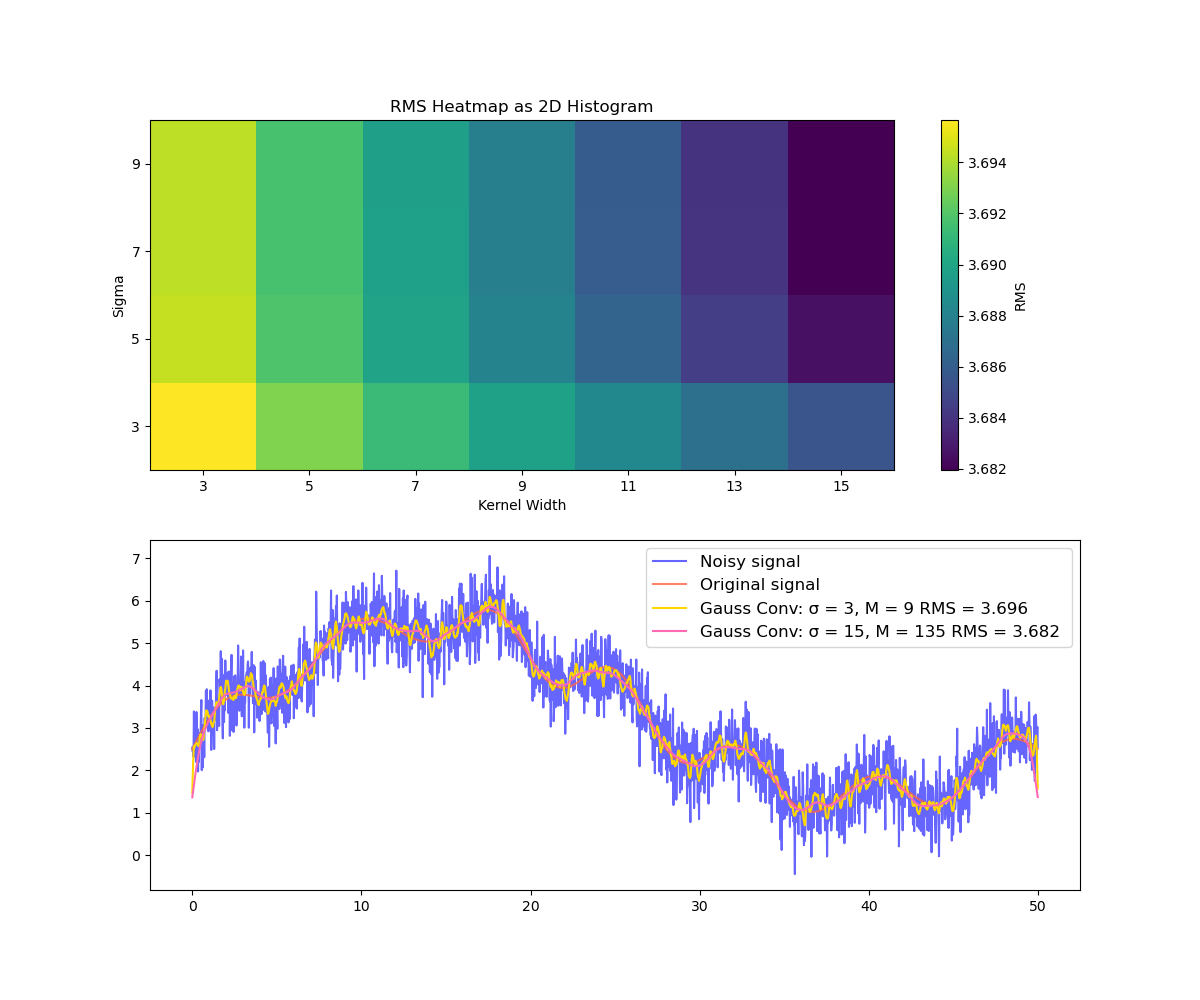

In [9]:
# TEST WITH MULTIPLE SIGMAS AND WIDTHS 

sigmas = np.array([3,5,7,9,11,13,15]) 
k_width = np.array([3,5,7,9]) 

S, K = np.meshgrid(sigmas, k_width)    # Meshgrid for vectorization

def Gauss_smoothing_scan(S,K, signal):    # VECTORIZED VERSION
    Gaussians =np.empty(S.shape,dtype=object)
    Smoothed =np.empty(S.shape,dtype=object)
    for i in range(S.shape[0]):   # Cycles over everything
        for j in range(S.shape[1]):
            sigma = S[i, j]
            k = K[i, j]

            M = int(k * sigma)
            if M % 2 == 0:
                M += 1  

            g = gaussian(M, sigma)
            g /= g.sum()  # Normalize
            Gaussians[i, j] = g

            Smoothed[i,j] = scipy.signal.convolve(signal, Gaussians[i, j], mode='same', method='auto')

    return Smoothed, Gaussians

def RMS(Signals):
    rms = np.empty(Signals.shape,dtype=object)
    for i in range(Signals.shape[0]):   # Cycles over everything
        for j in range(Signals.shape[1]):
            Sig = Signals[i, j]
            rms[i, j] = np.sqrt(np.mean(np.square(Sig)))
    return rms


Gauss_smoothings, Models = Gauss_smoothing_scan(S,K,noisy)


RMSs = RMS(Gauss_smoothings)
    
   
fig = plt.figure(figsize=(12, 10))


ax1 = fig.add_subplot(211)

# Creates edges for the 2D histo plot

sigma_edges = np.zeros(len(sigmas)+1)
sigma_edges[1:-1] = (sigmas[:-1] + sigmas[1:])/2
sigma_edges[0] = sigmas[0] - (sigmas[1]-sigmas[0])/2
sigma_edges[-1] = sigmas[-1] + (sigmas[-1]-sigmas[-2])/2

k_edges = np.zeros(len(k_width)+1)
k_edges[1:-1] = (k_width[:-1] + k_width[1:])/2
k_edges[0] = k_width[0] - (k_width[1]-k_width[0])/2
k_edges[-1] = k_width[-1] + (k_width[-1]-k_width[-2])/2

# Centers for visualization

sigma_centers = (sigma_edges[:-1] + sigma_edges[1:]) / 2
k_centers = (k_edges[:-1] + k_edges[1:]) / 2

          
A = S.flatten()   
B = K.flatten() 
weights = np.array(RMSs, dtype=float).flatten()

h = ax1.hist2d(
    A, B,
    bins=[sigma_edges, k_edges],  
    weights=weights,                   
    cmap='viridis'
)


cbar = plt.colorbar(h[3], ax=ax1)
cbar.set_label('RMS')
ax1.set_yticks(k_centers)
ax1.set_xticks(sigma_centers)


ax1.set_xlabel('Kernel Width')
ax1.set_ylabel('Sigma')
ax1.set_title('RMS Heatmap as 2D Histogram')




# Draws the best results (obv the one with largest sigma and widths)
ax2 = fig.add_subplot(212)

minRMS = np.min(RMSs)

indices = np.where(RMSs == minRMS)
a = indices[0][0]
b = indices[1][0]

ax2.plot(x,noisy, color='blue', alpha=0.6, label='Noisy signal')

maxRMS = np.max(RMSs)
nasty = np.where(RMSs == maxRMS)
c = nasty[0][0]
d = nasty[1][0]



ax2.plot(x,orig, color='tomato', alpha=0.8, label='Original signal')
ax2.plot(x,Gauss_smoothings[c,d], color='gold', alpha=1, label=f"Gauss Conv: σ = {S[c,d]:.0f}, M = {S[c,d]*K[c,d]} RMS = {RMSs[c,d]:.3f} ")
ax2.plot(x,Gauss_smoothings[a,b], color='hotpink', alpha=1, label=f"Gauss Conv: σ = {S[a,b]:.0f}, M = {S[a,b]*K[a,b]} RMS = {RMSs[a,b]:.3f} ")
ax2.legend(fontsize='large')
ax2.grid(False)

plt.show()






